# UMAP solver

uses the models generated in youmap.ipynb


In [2]:
import umap
import math
import dataclasses
import pickle
import random
import numpy as np
import os
import time
import multiprocessing
from joblib import Parallel, delayed
import re
from functools import lru_cache
from annoy import AnnoyIndex
from tqdm.notebook import tqdm
from scipy.spatial.distance import euclidean, pdist, squareform
import scipy
import scipy.stats as stats
from sklearn.decomposition import PCA, TruncatedSVD
from scipy.spatial.distance import cosine as cos_dist
from sklearn.preprocessing import normalize, StandardScaler
from gensim import models
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
from scipy.stats import binned_statistic
from typing import *

In [4]:
DATA_DIR = '/home/theo/repos/semantle/'

In [182]:
def read_goog_file(size=None):
    vec_file = DATA_DIR + 'GoogleNews-vectors-negative300.bin'
    kv = models.KeyedVectors.load_word2vec_format(vec_file, binary=True, limit=size)
    words = kv.index_to_key
    w_vecs = {}
    good_word = re.compile(r'^[a-z]+$')
    for w in words:
        # filter out proper nouns, pictograms, emoji, multi-words, etc. Eliminates 95% of the dataset.   
        if not good_word.match(w):
            continue
        w_vecs[w] = kv[w] / np.linalg.norm(kv[w])
    mat_full = np.array([w_vecs[w] for w in w_vecs])
    w_list = list(w_vecs.keys())
    return w_list, normalize(mat_full, axis=1)

w_list, orig_mat = read_goog_file()

In [183]:
# get stuff we need from prior experiments
with open(DATA_DIR+'w_list_155060.pkl', 'rb') as fh:
    w_list = pickle.load(fh)

umap_files = []
for fn in os.listdir(DATA_DIR):
    if fn.startswith('umap_155060'):
        umap_files.append(fn)

@dataclasses.dataclass
class UMAPFile():
    name: str
    rows: int
    dims: int
    nns: int
    curve: list


with open(DATA_DIR+'umap_curves.pkl', 'rb') as fh:
    curves = pickle.load(fh)
for c in curves:
    c.name = DATA_DIR + c.name.split('/')[-1]


In [7]:
# core semantle-solver stuff
def build_index(w_vecs: Dict[str, List[float]]) -> Tuple[Dict[int, str], AnnoyIndex]:
    for v in w_vecs.values():
        GLOVE_VEC_SIZE = len(v)
        break
    idx_to_word = {}
    ann_index = AnnoyIndex(GLOVE_VEC_SIZE, 'euclidean')
    with tqdm(total=len(w_vecs)) as pbar:
        for i, w in enumerate(w_vecs.keys()):
            pbar.update(1)
            ann_index.add_item(i, w_vecs[w])
            idx_to_word[i] = w
    ann_index.build(20) # n trees
    return idx_to_word, ann_index

In [221]:
def random_point_in_dist(point, dist):
    # For when we know the dist but have no idea what direction to travel
    vec = np.random.random((len(point)))
    vec = vec / scipy.linalg.norm(vec)
    vec = vec * dist*0.5
    return vec+point


def directed_point_in_dist(p1, p2, p1_dist, p2_dist):
    # Generate a vector using p1 and p2.
    # Check if it will point in the general direction of our target.
    p1p2 = (p1-p2)
    p1p2mag = scipy.linalg.norm(p1p2)
    if p1p2mag < 0.0000001:
        return None, 0
    p1p2_unit = p1p2 / p1p2mag
    if p1_dist < p2_dist:
        # p1 is closer to target
        mag = p1_dist
        target_point = p1 + p1p2_unit*mag
        confidence = (p2_dist-p1_dist) / p1p2mag
        assert confidence >= 0
    else:
        # j is closer to target
        # make a vector from j to a target that is dists[j] away
        mag = p2_dist
        target_point = p2 - p1p2_unit*mag
        confidence = (p1_dist-p2_dist) / p1p2mag
        assert confidence >= 0
    return target_point, confidence

In [9]:
def score_to_dist(score: float, curve: List[float]):
    # convert a [-100..100] semantle score (which is cos sim * 100) to a euclidean distance in reduced space
    c_dist = 1 - (score / 100)
    p3, p2, p1 = curve
    y = p3 / (1 + np.exp(-p2*(c_dist-p1)))
    return y


In [10]:
class SemantleGame():
    def __init__(self, w_list):
        self.orig_mat = orig_mat
        self.w_list = w_list
        self.target_word = random.choice(['banana', 'leaving', 'three', 'fortunate', 'electric', 'ended', 'swim', 
       'retch', 'flute', 'hands', 'trench', 'painful', 'airborne', 'safety', 'give',
       'never', 'ferocious', 'splitter', 'raccoon', 'pickle', 'microphone', 'love',
       'zombie', 'undulate', 'semicircle', 'book', 'doctor', 'arrow', 'fridge', 'merry',
       'crank', 'similar', 'flew', 'knock', 'neighbor', 'cell', 'cloud', 'moon', 'zebra',
       'therefore', 'abrupt', 'rend', 'knife', 'shill', 'dollar', 'spilled', 'carpet',
       'lunatic', 'beach', 'revert', 'future', 'nigh', 'drake', 'winded', 'play', 'freedom'])
        idx = w_list.index(self.target_word)
        self.target_vec = orig_mat[idx, :]
        
    def guess(self, word, orig_mat) -> Tuple[bool, float]:
        # construct guess
        idx = self.w_list.index(word)
        vec = orig_mat[idx, :]
        semantle_score = (1-cos_dist(vec, self.target_vec))*100
        if word == self.target_word:
            return True, semantle_score
        else:
            return False, semantle_score
    
    def display_guesses(self):
        s = []
        for g in sorted(self.guesses, key = lambda g: g.dist):
            s.append(str(g))
        print('\n'.join(s))
        
    def __str__(self):
        return '\n'.join('{}: {}'.format(k, v) for k, v in self.__dict__.items())

In [167]:
@dataclasses.dataclass
class Guess:
    word: str
    num: int
    dist: float
    score: float
    
class SemantleSolver:
    
    def __init__(self, curve=None, n_random_guesses=5, game=None, conf_thresh=0.1, first_guess=None):
        self.first_guess = first_guess
        self.n_random_guesses = n_random_guesses
        self.closest_dist = float('inf')
        self.guesses = []  # List[Guess]
        self.guessed_words = set()  # for fast lookup
        self.best_guess = None
        self.game = game
        self.curve = curve
        
        self.CONF_THRESH = conf_thresh
        
        self.stats = {
            'grd_high_conf': 0,
            'grd_random_dist': 0,
            'times_gradient': 0,
            'times_exhaustive': 0,
            'times_random': 0,
        }
        
    def _gradient_method(self, w_vecs, ann_index):
        # Use gradient method to get a closer guess.
        p1 = np.array(w_vecs[self.guesses[-1].word])
        p1_dist = self.guesses[-1].dist
        
        # Consider the few most recent points. 
        # Try and find one with a vector through p1 that points towards the target.
        best_point = None
        best_confidence = 0
        best_p2_dist = float('inf')
        for i in range(2, min(10, len(self.guesses))):
            p2 = np.array(w_vecs[self.guesses[-i].word])
            p2_dist = self.guesses[-i].dist
            
            # where does p2->p1 point? and how well aligned is that spot with the target?
            target_point, confidence = directed_point_in_dist(p1, p2, p1_dist, p2_dist)
            if confidence > best_confidence:
                best_confidence = confidence
                best_point = target_point
        if best_confidence < self.CONF_THRESH:
            self.stats['grd_random_dist'] += 1
            vec = np.array(w_vecs[self.best_guess])
            best_point = random_point_in_dist(vec, self.closest_dist)
            #print('grd_rand')
        else:
            self.stats['grd_high_conf'] += 1
            #print('grd_conf')

        return best_point

    
    def find_next_guess(self, w_vecs, ann_index, idx_to_word) -> bool:
        if len(self.guesses) == 0:
            next_word = self.first_guess
        elif len(self.guesses) < self.n_random_guesses:
            self.stats['times_random'] += 1
            next_word = random.choice(list(w_vecs.keys()))
        else:
            self.stats['times_gradient'] += 1
            v = self._gradient_method(w_vecs, ann_index)
            idxs_near_best = ann_index.get_nns_by_vector(v, 1000)
            for idx in idxs_near_best:
                w = idx_to_word[idx]
                if w not in self.guessed_words:
                    next_word = w
                    break
            
        return next_word

    def make_guess(self, word, orig_mat):
        # guess the word
        win, score = self.game.guess(word, orig_mat)
        dist = score_to_dist(score, self.curve)
        self.guessed_words.add(word)
        self.guesses.append(Guess(word=word, dist=dist, num=len(self.guesses)+1, score=score))
        
        # see if this one's better
        if self.best_guess is None or dist < self.closest_dist:
            #print(word, round(dist, 3))
            self.closest_dist = dist
            self.best_guess = word
        
        if win:
            #print("I win!")
            return True
        else:
            return False
    
    def add_guess(self, word, score):
        # Adds a guess from an external source. For playing Real Semantle.
        dist = score_to_dist(score, self.curve)
        self.guessed_words.add(word)
        self.guesses.append(Guess(word=word, dist=dist, num=len(self.guesses)+1, score=score))
        if self.best_guess is None or dist < self.closest_dist:
            #print(word, round(dist, 3))
            self.closest_dist = dist
            self.best_guess = word
        

In [215]:
def set_up(src, curves):
    curve = []
    for c in curves:
        if src in c.name:
            curve = c.curve
    assert len(curve)
    mat = np.load(src)

    n_words = mat.shape[0]
    wfile = DATA_DIR + 'w_list_{}.pkl'.format(n_words)
    with open(wfile, 'rb') as fh:
        w_list = pickle.load(fh)
    
    # ugh, fine.
    w_vecs = {}
    for i in range(mat.shape[0]):
        w_vecs[w_list[i]] = mat[i, :]
    idx_to_word, ann_index = build_index(w_vecs)  # fast
    return mat, w_vecs, curve, w_list, idx_to_word, ann_index

mat, w_vecs, curve, w_list, idx_to_word, ann_index = set_up(DATA_DIR+'umap_155060rows_30dims_15nns.npy', curves)

  0%|          | 0/155060 [00:00<?, ?it/s]

In [207]:
# UMAP is having trouble at the start because of its lack of global structure. 
# If we seed it with a hint (e.g one that another method would come up with), does it start to shine?

@dataclasses.dataclass
class WordPair():
    w1: str
    w2: str
    dist: float
    
    def __str__(self):
        return '{} -> {}: {}'.format(self.w1, self.w2, self.dist)

with open(DATA_DIR+'word_pairs.pkl', 'rb') as fh:
    word_pairs = pickle.load(fh)

hints = {}
for w in word_pairs:
    if 0.45 < w.dist < 0.55:
        hints[w.w1] = w.w2

for w in word_pairs:
    if 0.55 < w.dist < 0.6:
        if not hints.get(w.w1, False):
            hints[w.w1] = w.w2


dollar
{'grd_high_conf': 51, 'grd_random_dist': 3, 'times_gradient': 54, 'times_exhaustive': 0, 'times_random': 9}
safety
{'grd_high_conf': 2, 'grd_random_dist': 1, 'times_gradient': 3, 'times_exhaustive': 0, 'times_random': 9}
shill
{'grd_high_conf': 914, 'grd_random_dist': 76, 'times_gradient': 990, 'times_exhaustive': 0, 'times_random': 9}
flew
{'grd_high_conf': 349, 'grd_random_dist': 69, 'times_gradient': 418, 'times_exhaustive': 0, 'times_random': 9}
doctor
{'grd_high_conf': 163, 'grd_random_dist': 5, 'times_gradient': 168, 'times_exhaustive': 0, 'times_random': 9}
painful
{'grd_high_conf': 364, 'grd_random_dist': 36, 'times_gradient': 400, 'times_exhaustive': 0, 'times_random': 9}
nigh
{'grd_high_conf': 495, 'grd_random_dist': 495, 'times_gradient': 990, 'times_exhaustive': 0, 'times_random': 9}
pickle
{'grd_high_conf': 397, 'grd_random_dist': 13, 'times_gradient': 410, 'times_exhaustive': 0, 'times_random': 9}
lunatic
{'grd_high_conf': 33, 'grd_random_dist': 9, 'times_gradient'

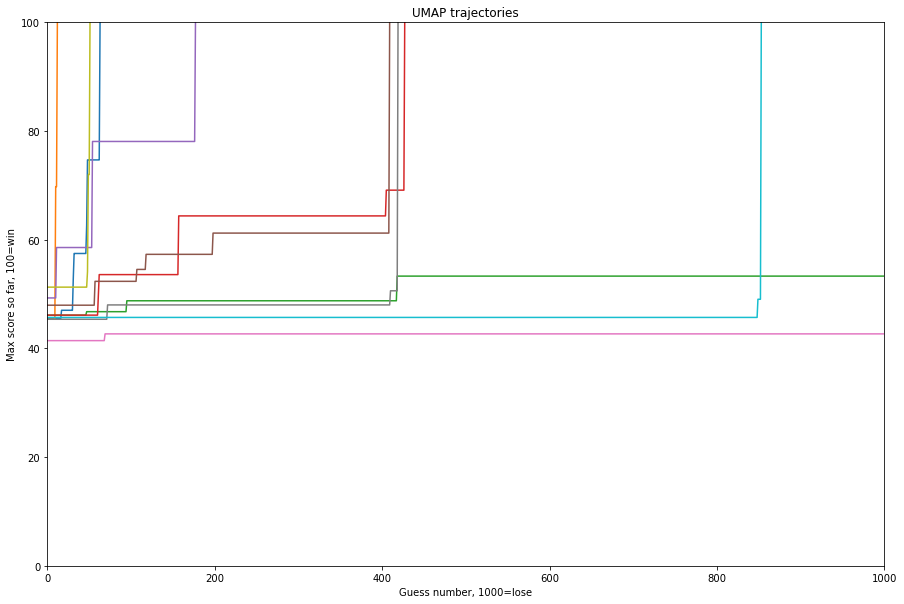

In [222]:
plt.figure(figsize=(15,10))

for _ in range(10):
    game = SemantleGame(w_list)
    game.target_word
    player = SemantleSolver(game=game, curve=curve, n_random_guesses=10, 
                            conf_thresh=0.9, first_guess=hints[game.target_word])
    print(game.target_word)
    won = False
    while not won:
        word = player.find_next_guess(w_vecs, ann_index, idx_to_word)
        won = player.make_guess(word, orig_mat)
        g = player.guesses[-1]
        local_dist = score_to_dist(g.score, curve)
        #print(g.word, round(g.score, 3), '->', round(local_dist, 3))
        if len(player.guesses) >= 1000:
            #print('stopped. ')
            #print('Best guess:', player.best_guess, 'dist:', player.closest_dist)
            break
    print(player.stats)

    max_score = 0
    traj = []
    for g in player.guesses:
        max_score = max(g.score, max_score)
        traj.append(max_score)
        
    plt.plot(range(len(traj)), traj, '-')
    plt.xlim(0, 1000)
    plt.ylim(0, 100)
    plt.title('UMAP trajectories')
    plt.ylabel('Max score so far, 100=win')
    plt.xlabel('Guess number, 1000=lose')

# Trying all the umaps to find the best one

10 and 30 dims @ 50nns did the best, though none of them did great.

In [20]:
ngs = {}
for c in curves:
    if '155' not in c.name:
        # just solving the reduced dataset here.
        continue
    if not len(c.curve):
        continue
    mat, w_vecs, curve, w_list, idx_to_word, ann_index = set_up(c.name, curves)
    ngs[c.name] = []
    for i in range(25):
        game = SemantleGame(w_list)
        player = SemantleSolver(game=game, curve=curve, n_random_guesses=2, conf_thresh=0.6)
        print(game.target_word)
        #print(player.CONF_THRESH)
        won = False
        while not won:
            word = player.find_next_guess(w_vecs, ann_index, idx_to_word)
            won = player.make_guess(word, orig_mat)
            #g = player.guesses[-1]
            #local_dist = score_to_dist(g.score, curve)
            #print(g.word, round(g.score, 3), '->', round(local_dist, 3))
            if len(player.guesses) >= 1000:
                #print('stopped. ')
                #print('Best guess:', player.best_guess, 'dist:', player.closest_dist)
                break

        #print(len(player.guesses))
        ngs[c.name].append(len(player.guesses))
    v = ngs[c.name]
    print(c.name.split('/')[-1])
    print(v)
    print("PASSED:", sum(1 for r in v if r != 1000), '/', len(v))
for k, v in ngs.items():
    print(sum(v)/len(v), k.split('/')[-1])

  0%|          | 0/155060 [00:00<?, ?it/s]

three
nigh
nigh
pickle
rend
flew
semicircle
cloud
carpet
pickle
fortunate
retch
leaving
similar
play
painful
therefore
safety
leaving
banana
zebra
swim
fridge
ferocious
pickle
umap_155060rows_3dims_15nns.npy
[1000, 1000, 1000, 1000, 1000, 843, 1000, 612, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 825, 423, 237, 285, 1000, 1000]
PASSED: 6 / 25


  0%|          | 0/155060 [00:00<?, ?it/s]

moon
therefore
undulate
carpet
undulate
microphone
revert
airborne
beach
flew
cloud
rend
flute
book
swim
hands
cell
play
dollar
airborne
trench
rend
future
book
microphone
umap_155060rows_3dims_50nns.npy
[1000, 1000, 1000, 1000, 588, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 239, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]
PASSED: 2 / 25


  0%|          | 0/155060 [00:00<?, ?it/s]

microphone
banana
dollar
moon
knife
play
revert
give
three
never
crank
knife
carpet
cloud
moon
flute
lunatic
love
safety
swim
dollar
safety
leaving
lunatic
airborne
umap_155060rows_3dims_100nns.npy
[1000, 653, 479, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 99, 532, 1000, 1000, 1000, 1000, 1000, 1000, 697, 1000]
PASSED: 5 / 25


  0%|          | 0/155060 [00:00<?, ?it/s]

rend
doctor
pickle
crank
drake
cell
rend
merry
moon
drake
shill
moon
knock
semicircle
lunatic
beach
knife
swim
never
painful
crank
give
cell
electric
swim
umap_155060rows_3dims_1000nns.npy
[1000, 404, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 484, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]
PASSED: 2 / 25


  0%|          | 0/155060 [00:00<?, ?it/s]

flute
splitter
three
give
microphone
future
give
fridge
raccoon
nigh
moon
dollar
electric
airborne
safety
semicircle
ferocious
splitter
freedom
electric
winded
spilled
rend
doctor
banana
umap_155060rows_10dims_15nns.npy
[81, 1000, 142, 1000, 1000, 1000, 488, 555, 521, 1000, 178, 77, 1000, 1000, 274, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 396, 285]
PASSED: 10 / 25


  0%|          | 0/155060 [00:00<?, ?it/s]

doctor
fortunate
dollar
electric
safety
knife
abrupt
neighbor
crank
swim
safety
fortunate
neighbor
beach
neighbor
nigh
zebra
knock
spilled
flute
leaving
flute
airborne
swim
ferocious
umap_155060rows_10dims_50nns.npy
[1000, 141, 206, 1000, 1000, 824, 1000, 60, 1000, 546, 1000, 93, 589, 518, 180, 1000, 535, 1000, 1000, 233, 1000, 262, 1000, 1000, 995]
PASSED: 13 / 25


  0%|          | 0/155060 [00:00<?, ?it/s]

give
flute
safety
play
zebra
splitter
book
abrupt
zombie
knock
revert
three
trench
cloud
moon
trench
freedom
revert
flew
knock
undulate
hands
safety
arrow
airborne
umap_155060rows_10dims_100nns.npy
[976, 34, 1000, 1000, 512, 1000, 455, 1000, 182, 505, 1000, 336, 1000, 498, 137, 1000, 156, 1000, 154, 1000, 429, 1000, 1000, 459, 1000]
PASSED: 13 / 25


  0%|          | 0/155060 [00:00<?, ?it/s]

hands
future
winded
love
zombie
knock
airborne
airborne
undulate
shill
fortunate
rend
swim
rend
never
leaving
neighbor
drake
merry
electric
leaving
rend
safety
freedom
flew
umap_155060rows_10dims_1000nns.npy
[418, 943, 1000, 1000, 445, 1000, 1000, 1000, 410, 1000, 285, 935, 261, 1000, 416, 1000, 1000, 242, 1000, 1000, 654, 1000, 1000, 362, 451]
PASSED: 12 / 25


  0%|          | 0/155060 [00:00<?, ?it/s]

knife
knife
book
drake
play
safety
pickle
dollar
electric
fridge
similar
retch
undulate
trench
safety
neighbor
drake
knock
future
fridge
zombie
hands
trench
raccoon
leaving
umap_155060rows_30dims_15nns.npy
[1000, 1000, 372, 1000, 996, 1000, 1000, 1000, 1000, 321, 1000, 453, 354, 637, 1000, 363, 1000, 465, 1000, 1000, 1000, 597, 559, 1000, 1000]
PASSED: 10 / 25


  0%|          | 0/155060 [00:00<?, ?it/s]

dollar
retch
freedom
knock
merry
painful
future
banana
undulate
pickle
electric
doctor
microphone
safety
rend
shill
spilled
abrupt
three
pickle
spilled
drake
give
trench
drake
umap_155060rows_30dims_50nns.npy
[1000, 551, 160, 1000, 1000, 1000, 1000, 54, 955, 1000, 1000, 120, 643, 1000, 1000, 1000, 1000, 1000, 156, 1000, 1000, 406, 1000, 1000, 337]
PASSED: 9 / 25


  0%|          | 0/155060 [00:00<?, ?it/s]

therefore
crank
rend
rend
zombie
rend
leaving
nigh
raccoon
give
winded
swim
nigh
pickle
drake
fortunate
never
rend
crank
zombie
abrupt
hands
safety
undulate
merry
umap_155060rows_30dims_100nns.npy
[692, 1000, 1000, 1000, 393, 1000, 1000, 1000, 299, 1000, 1000, 33, 1000, 1000, 1000, 1000, 271, 1000, 1000, 149, 1000, 1000, 1000, 92, 1000]
PASSED: 7 / 25


  0%|          | 0/155060 [00:00<?, ?it/s]

book
electric
freedom
undulate
painful
future
painful
knife
flute
cell
ended
shill
ferocious
swim
undulate
splitter
crank
flew
safety
undulate
drake
play
flute
carpet
spilled
umap_155060rows_30dims_1000nns.npy
[614, 1000, 788, 141, 1000, 1000, 1000, 1000, 446, 1000, 827, 1000, 795, 120, 253, 621, 1000, 1000, 1000, 553, 1000, 1000, 50, 1000, 323]
PASSED: 12 / 25


  0%|          | 0/155060 [00:00<?, ?it/s]

microphone
undulate
revert
cell
flute
zombie
shill
lunatic
fortunate
painful
future
knife
pickle
swim
cell
splitter
similar
safety
give
microphone
neighbor
cell
shill
arrow
undulate
umap_155060rows_100dims_15nns.npy
[121, 607, 1000, 1000, 153, 1000, 1000, 160, 343, 1000, 803, 1000, 1000, 50, 464, 1000, 1000, 1000, 1000, 942, 1000, 583, 756, 1000, 418]
PASSED: 12 / 25


  0%|          | 0/155060 [00:00<?, ?it/s]

zebra
three
moon
knock
hands
play
love
love
rend
cell
neighbor
doctor
carpet
knock
zebra
cell
love
future
airborne
crank
trench
doctor
flute
doctor
cloud
umap_155060rows_100dims_50nns.npy
[590, 96, 1000, 1000, 355, 1000, 1000, 1000, 1000, 790, 270, 88, 1000, 957, 837, 1000, 1000, 1000, 1000, 1000, 182, 1000, 163, 637, 1000]
PASSED: 11 / 25


  0%|          | 0/155060 [00:00<?, ?it/s]

raccoon
shill
doctor
retch
similar
fridge
raccoon
abrupt
beach
zebra
zebra
flute
safety
love
play
microphone
trench
crank
microphone
leaving
lunatic
similar
doctor
splitter
therefore
umap_155060rows_100dims_100nns.npy
[346, 1000, 897, 1000, 1000, 733, 467, 1000, 1000, 1000, 815, 213, 1000, 1000, 1000, 231, 1000, 1000, 488, 1000, 33, 1000, 86, 1000, 451]
PASSED: 11 / 25


  0%|          | 0/155060 [00:00<?, ?it/s]

book
zebra
spilled
spilled
fortunate
hands
knock
retch
play
book
future
doctor
spilled
zombie
neighbor
abrupt
therefore
cloud
ferocious
nigh
revert
safety
semicircle
shill
flew
umap_155060rows_100dims_1000nns.npy
[76, 372, 1000, 1000, 365, 266, 1000, 1000, 1000, 344, 1000, 204, 1000, 502, 132, 1000, 470, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 905]
PASSED: 10 / 25
889.0 umap_155060rows_3dims_15nns.npy
953.08 umap_155060rows_3dims_50nns.npy
898.4 umap_155060rows_3dims_100nns.npy
955.52 umap_155060rows_3dims_1000nns.npy
719.88 umap_155060rows_10dims_15nns.npy
687.28 umap_155060rows_10dims_50nns.npy
673.32 umap_155060rows_10dims_100nns.npy
752.88 umap_155060rows_10dims_1000nns.npy
804.68 umap_155060rows_30dims_15nns.npy
775.28 umap_155060rows_30dims_50nns.npy
797.16 umap_155060rows_30dims_100nns.npy
741.24 umap_155060rows_30dims_1000nns.npy
736.0 umap_155060rows_100dims_15nns.npy
758.6 umap_155060rows_100dims_50nns.npy
750.4 umap_155060rows_100dims_100nns.npy
745.44 umap_155060rows_100d

In [ ]:
# 10 and 30 dims did fine really. Splitting hairs beyond that.
best_ones = ['umap_155060rows_10dims_50nns.npy', 'umap_155060rows_30dims_50nns']